In [9]:
'''2d_cellpose.ipynbtesting some preprocessing
can also use simple itk functions directly, such as for med filter
and try top-hat bg substraction from cyclemanto instead of rolling ball
'''

'2d_cellpose.ipynbtesting some preprocessing\ncan also use simple itk functions directly, such as for med filter\nand try top-hat bg substraction from cyclemanto instead of rolling ball\n'

In [5]:
# activate analysis env
import numpy as np
from skimage import exposure, util
from skimage import io
import matplotlib.pyplot as plt
import cv2
import os
from imageio import imread

In [6]:
image_path = "H:/PROJECTS-03/Feyza/240925-NcadGFPxH2Bch-HIGHRES/20240925_151619_20240925_NcadxH2B_05z_timelapse/3d_segmentation_test/pos4-t1-cropped-raw.tif"  # Replace with the actual path
img_raw = imread(image_path)
print(f'Loaded image in an array of shape: {img_raw.shape} and data type {img_raw.dtype}')


C:\Users\fnarslan\AppData\Local\Temp\38\ipykernel_49072\946398432.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_raw = imread(image_path)


Loaded image in an array of shape: (240, 2, 708, 1294) and data type uint16


### CLAHE

In [ ]:
# Determine kernel sizes in each dim relative to image shape
# Define CLAHE parameters
kernel_size = (img_raw.shape[0] // 8, img_raw.shape[2] // 8, img_raw.shape[3] // 8)  # 3D kernel across time/slices and spatial dimensions
clip_limit = 0.01
kernel_size = np.array(kernel_size)

# Split the channels
channel_0 = img_raw[:, 0, :, :]  # Extract the first channel (shape: 240, 708, 1294)
channel_1 = img_raw[:, 1, :, :]  # Extract the second channel (shape: 240, 708, 1294)

# Apply 3D adaptive histogram equalization to each channel
channel_0_clahe = exposure.equalize_adapthist(channel_0, kernel_size=kernel_size, clip_limit=clip_limit)
channel_1_clahe = exposure.equalize_adapthist(channel_1, kernel_size=kernel_size, clip_limit=clip_limit)

# Merge the channels back together
img_clahe = np.stack((channel_0_clahe, channel_1_clahe), axis=1)  # Shape: (240, 2, 708, 1294)


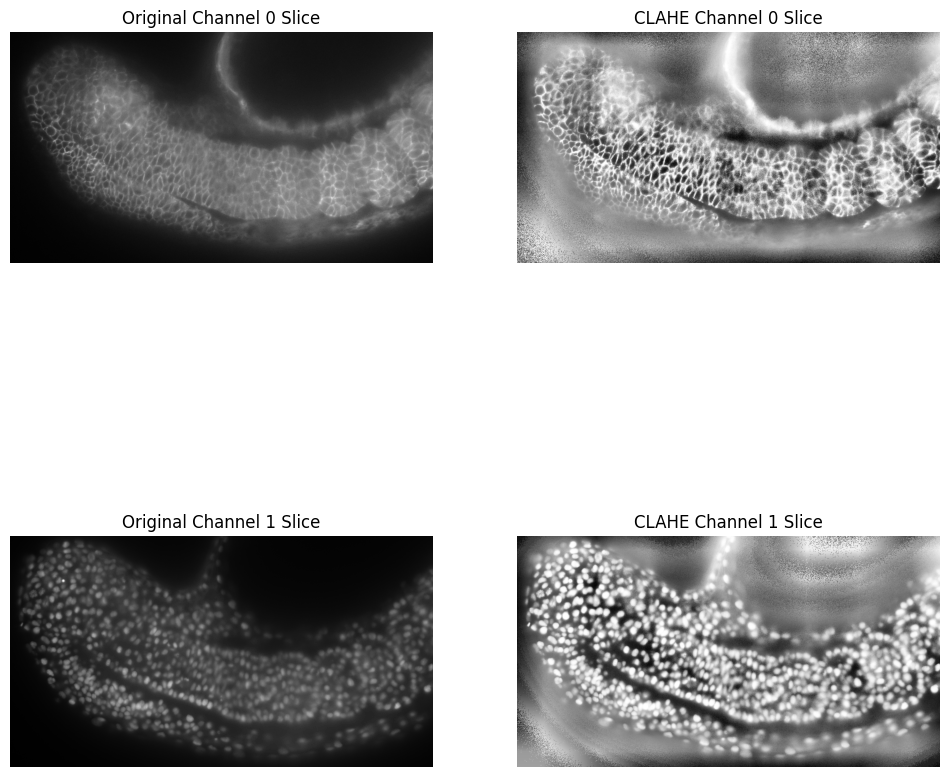

In [19]:
# Display an example slice from each channel before and after CLAHE
slice_index = 150  # Choose a slice index to visualize

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
# Original slices
axes[0, 0].imshow(img_raw[slice_index, 0], cmap='gray')
axes[0, 0].set_title('Original Channel 0 Slice')
axes[0, 0].axis('off')

axes[1, 0].imshow(img_raw[slice_index, 1], cmap='gray')
axes[1, 0].set_title('Original Channel 1 Slice')
axes[1, 0].axis('off')

# CLAHE applied slices
axes[0, 1].imshow(img_clahe[slice_index, 0], cmap='gray')
axes[0, 1].set_title('CLAHE Channel 0 Slice')
axes[0, 1].axis('off')

axes[1, 1].imshow(img_clahe[slice_index, 1], cmap='gray')
axes[1, 1].set_title('CLAHE Channel 1 Slice')
axes[1, 1].axis('off')

plt.show()

In [20]:
# save image to the same directory
base, ext = os.path.splitext(image_path)
output_path = f"{base}_clahe_clip5{ext}"
io.imsave(output_path, (img_clahe * 65535).astype(np.uint16))  # Scale to uint16 for saving


### Background substraction

In [ ]:
# might need to pass a gaussian filter before if the image is salt and pepper
# first trying out the bg substraction on image j to test

def ellipsoid_kernel(shape, radius):
    z, y, x = shape
    a, b, c = z / 2, y / 2, x / 2
    z_grid, y_grid, x_grid = np.ogrid[
        -a:a+1, -b:b+1, -c:c+1]
    ellipsoid = (z_grid / a) ** 2 + (y_grid / b) ** 2 + (x_grid / c) ** 2 <= 1
    return ellipsoid.astype(float)

def subtract_background(img, bg_radius=0):
    if bg_radius == 0:
        return img
    kernel = ellipsoid_kernel((1, bg_radius, bg_radius), bg_radius)
    bg = rolling_ball(img, kernel=kernel)
    return img - bg






In [8]:
# Split the channels
channel_0 = img_raw[:, 0, :, :]  # Extract the first channel (shape: 240, 708, 1294)
channel_1 = img_raw[:, 1, :, :]  # Extract the second channel (shape: 240, 708, 1294)

params = {'bg_radius': 20}
channel_0 = subtract_background(channel_0, bg_radius=params['bg_radius'])
plt.imshow(channel_0[100])

NameError: name 'rolling_ball' is not defined

### Median filtering

In [2]:
def median_xy(img, radius=0):
    if radius == 0:
        return img
    return to_numpy(median(to_itk(img), radius=(radius, radius, 0)))

In [ ]:
params = {'bg_radius': 20, 'median_radius': 1}


channel_0 = exposure.equalize_adapthist(channel_0, clip_limit=0.01)
plt.imshow(channel_0[100])
channel_0 = subtract_background(channel_0, bg_radius=params['bg_radius'])
plt.imshow(channel_0[100])
channel_0 = median_xy(channel_0, radius=params['median_radius'])
plt.imshow(channel_0[100])


channel_1 = exposure.equalize_adapthist(channel_1, clip_limit=0.01)
channel_1 = subtract_background(channel_1, bg_radius=params['bg_radius'])
channel_1 = median_xy(channel_1, radius=params['median_radius'])


# Merge the channels back together
img_clahe_bgsub_medianfilt = np.stack((channel_0_clahe, channel_1_clahe), axis=1)  


# save image to the same directory
base, ext = os.path.splitext(image_path)
output_path = f"{base}_clahe_bgsub20_medianfilt1{ext}"
io.imsave(output_path, (img_clahe_bgsub_medianfilt * 65535).astype(np.uint16))  # Scale to uint16 for saving